<a href="https://colab.research.google.com/github/colaprograms/2019-hackathon-ocr-wymbah/blob/master/notebooks/ctc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, torch, re, sys
import numpy as np
import matplotlib.pyplot as p
import random, PIL

In [2]:
os.chdir("/content")
if not os.path.exists("/content/AI4Good---Meza-OCR-Challenge"):
  !git clone https://github.com/Charitable-Analytics-International/AI4Good---Meza-OCR-Challenge
if not os.path.exists("/content/2019-hackathon-ocr-wymbah"):
  !git clone https://github.com/colaprograms/2019-hackathon-ocr-wymbah
os.chdir("/content/2019-hackathon-ocr-wymbah")
!git pull

Cloning into 'AI4Good---Meza-OCR-Challenge'...
remote: Enumerating objects: 7253, done.
remote: Counting objects: 100% (7253/7253), done.
remote: Compressing objects: 100% (6863/6863), done.
remote: Total 7253 (delta 391), reused 7252 (delta 390), pack-reused 0
Receiving objects: 100% (7253/7253), 8.14 MiB | 5.89 MiB/s, done.
Resolving deltas: 100% (391/391), done.
Cloning into '2019-hackathon-ocr-wymbah'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 76 (delta 31), reused 39 (delta 12), pack-reused 0
Unpacking objects: 100% (76/76), done.
Already up to date.


(34, 84)
0.0 1.0


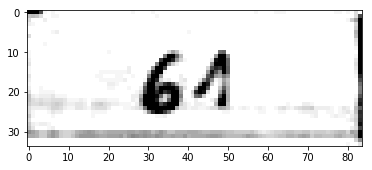

In [30]:
from util.file import train_file, FileHolder, to_buffer
fh = FileHolder()
filename, val = fh.random_training()

def clip(buf):
  grayscale = np.mean(buf, axis=2)
  print(grayscale.shape)
  flat = np.sort(grayscale.reshape(-1))
  top = flat[int(flat.shape[0] * 0.3)]
  bottom = flat[int(flat.shape[0] * 0.03)]
  buf = (buf - bottom) / (top - bottom)
  buf = np.clip(buf, 0, 1)
  return buf

image = to_buffer(train_file(filename), 128)
image = clip(image)
print(np.min(image), np.max(image))
p.imshow(image)
p.show()

In [39]:
import scipy
import scipy.misc

image = scipy.misc.imresize(image, 128 / image.shape[1])

['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'absolute_import', 'ascent', 'central_diff_weights', 'derivative', 'division', 'doccer', 'electrocardiogram', 'face', 'print_function', 'test']


AttributeError: ignored

In [0]:
import torch.nn as nn
import torch.optim as optim
import torchvision

In [0]:
resnet = torchvision.models.resnet.resnet34(True)

In [32]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
"Cut off the last two layers"
def forward(self, x):
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  x = self.maxpool(x)

  x = self.layer1(x)
  x = self.layer2(x)
  x = self.layer3(x)
  x = self.layer4(x)

  return x

import types
resnet.forward = types.MethodType(forward, resnet)

In [35]:
image_tensor = torch.Tensor(image)
image_tensor = torch.unsqueeze(image_tensor, 0)
image_tensor = image_tensor.permute(0, 3, 1, 2)
out = resnet(image_tensor)
print(out)
print(out.shape)

tensor([[[[0.0000, 1.8190, 2.2790],
          [0.0000, 0.1936, 2.7373]],

         [[0.0000, 0.5690, 0.9170],
          [0.0000, 2.3174, 2.8190]],

         [[0.0000, 1.0837, 1.9252],
          [0.0000, 0.2745, 1.9586]],

         ...,

         [[0.3714, 1.5718, 1.4087],
          [1.0323, 0.0000, 0.0000]],

         [[0.8162, 0.8420, 0.0000],
          [1.2914, 2.4282, 0.0000]],

         [[0.0000, 2.4219, 0.6046],
          [0.0000, 0.9700, 0.4857]]]], grad_fn=<ReluBackward1>)
torch.Size([1, 512, 2, 3])


In [18]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co